# Modeling

### Imports

In [4]:
#Data Handling
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

#Stats
from scipy import stats
from scipy.stats import norm, skew

#Warnings
import warnings

#Modeling
import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
#There are some additional modeling imports below
#Specifically for the Neural Net

#Modeling with XGBoost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

### Data

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

First I'm going to drop all properties with an above ground living area greater than 4000, as per both my analysis and the documentation of the data set.

In [7]:
index_drop = train[train["GrLivArea"] > 4000].index
train.drop(index = index_drop, inplace = True)
train.reset_index(drop = True, inplace = True)

Next I'm going to concatenate the training and test sets so that all feature engineering/dropping is applied to both sets. I'll also review and fill both sets NA values identically this way, guaranteeing that the two data sets have the same levels for all categorical features.

In [8]:
#Concatenating Test and Train for variable dropping/encoding/transforming etc.
train_SalePrice = train.loc[:,"SalePrice"]
train.drop(columns="SalePrice", inplace = True)

train["IsTrain"] = np.ones(shape = len(train))
test["IsTrain"] = np.zeros(shape = len(test))

test_id = test.loc[:,"Id"]

all_data = pd.concat([train, test]).reset_index(drop = True)
all_data.drop(columns = ["Id", "PoolArea", "PoolQC", "Fence", "MiscFeature", "MiscVal", "GarageYrBlt", "Alley", "Utilities"], inplace = True)

Now, based on the analysis done in the Main exploratory file, I'll be collapsing a few levels of interesting variables, as well as dropping  those variables which I found to have practically no relationship with the Sale Price (ie. both sale date variables) or which were found to be largely missing.

### Preprocessing

#### Filling Missing Values  
The majority of the missing values in the data set are due to the absence of a feature on the given property. This is specified in the data description file, and as such I've converted the NAN values to either 0's (in the numerical case) or to a categorical level of "None".  
Specified below are also a few variables which were filled with the mode of the respective feature. This was done as these features only experienced a very small number of missing values.

In [9]:
#treating missings using data description file info
#Filling with mean/median does not make sense for these entries
#LotFrontage
all_data.loc[:, "LotFrontage"] = all_data.loc[:, "LotFrontage"].fillna(0)

#Masonry
all_data.loc[:, "MasVnrType"] = all_data.loc[:, "MasVnrType"].fillna("None")
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)

#Basement:
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("None")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("None")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("None")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("None")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("None")
all_data.loc[:, "BsmtFinSF1"] = all_data.loc[:, "BsmtFinSF1"].fillna(0)
all_data.loc[:, "BsmtFinSF2"] = all_data.loc[:, "BsmtFinSF2"].fillna(0)
all_data.loc[:, "BsmtFullBath"] = all_data.loc[:, "BsmtFullBath"].fillna(0)
all_data.loc[:, "BsmtHalfBath"] = all_data.loc[:, "BsmtHalfBath"].fillna(0)
all_data.loc[:, "BsmtUnfSF"] = all_data.loc[:, "BsmtUnfSF"].fillna(0)
all_data.loc[:, "TotalBsmtSF"] = all_data.loc[:, "TotalBsmtSF"].fillna(0)


#Fireplace:
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("None")

#Garage:
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("None")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("None")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("None")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("None")
all_data.loc[:, "GarageCars"] = all_data.loc[:, "GarageCars"].fillna(0)
all_data.loc[:, "GarageArea"] = all_data.loc[:, "GarageArea"].fillna(0)


#Filling with Mode
#MSZoning
all_data.loc[:, "MSZoning"] = all_data.loc[:, "MSZoning"].fillna("RL")

#Exterior1st
all_data.loc[:, "Exterior1st"] = all_data.loc[:, "Exterior1st"].fillna("VinylSd")

#Exterior2nd
all_data.loc[:, "Exterior2nd"] = all_data.loc[:, "Exterior2nd"].fillna("VinylSd")

#Functional
all_data.loc[:, "Functional"] = all_data.loc[:, "Functional"].fillna("Typ")

#Electrical
all_data.loc[:, "Electrical"] = all_data.loc[:, "Electrical"].fillna("SBrkr")

#KitchenQual
all_data.loc[:, "KitchenQual"] = all_data.loc[:, "KitchenQual"].fillna("TA")

#SaleType
all_data.loc[:, "SaleType"] = all_data.loc[:, "SaleType"].fillna("WD")

Below I visualize the missing data in the data set one final to, just to double check that there are no eronious missing values that I have not caught.

Text(0.5, 1, 'Visualization of Missing Values in the All Data')

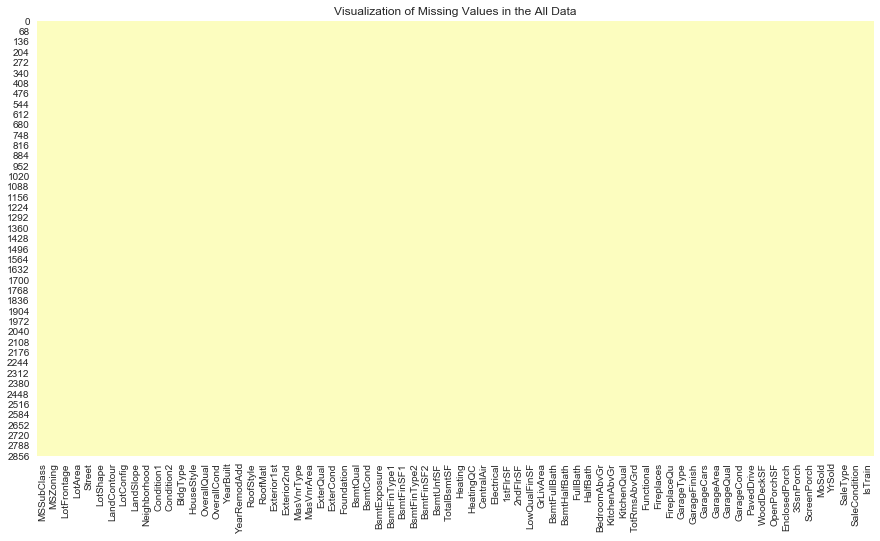

In [10]:
#visualizing the missing values in the training set
plt.figure(figsize=(15,8))
sns.heatmap(pd.isnull(all_data), cbar = False, cmap = "magma_r")
plt.title("Visualization of Missing Values in the All Data")

In [11]:
#Call the dataframe of observations with missing values
#If the dataframe is blank than I've successfully filled them all.
pd.set_option("display.max.columns", 999)
all_data[all_data.isnull().any(axis = 1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition,IsTrain


#### Encoding Numeric Variables which are Actually Categorical

In [12]:
all_data = all_data.replace(
    {"MSSubClass" : 
     {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 50 : "SC50",
     60 : "SC60", 70 : "SC70", 75 : "SC75", 80 : "SC80", 85 : "SC85",
     90 : "SC90", 120 : "SC120", 150: "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})
all_data["MSSubClass"] = all_data.MSSubClass.astype("object")

#### Order Encoding those Categorical Variables which should be Ordered  
Below I've encoded all the catergorical variables which were given levels respective to their quality with corresponding numeric values. Consistantly throughout the data set, low values will indicate poorer quality, while higher values will indicate better quality. Zero values show that the feature is absent.

In [13]:
all_data = all_data.replace(
    {"LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
    "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
    "ExterQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "ExterCond" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4}, #, "Ex" : 5}, There are no excellent condition basements in all the data
    "BsmtExposure" : {"None" : 0, "No" : 1, "Mn" : 2, "Av" : 3, "Gd" : 4},
    "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ" : 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "CentralAir" : {"N" : 0, "Y" : 1},
    "Electrical" : {"Mix" : 1, "FuseP" : 1, "FuseF" : 2, "FuseA" : 3, "SBrkr" : 4},
    "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod" : 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
    "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageFinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
    "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "PavedDrive" : {"N" : 1, "P" : 2, "Y" : 3}})

In [14]:
cate_feats = all_data.dtypes[all_data.dtypes == "object"].index
for feat in cate_feats:
    all_data[feat] = all_data[feat].astype("category")

from sklearn.preprocessing import LabelEncoder
cate_feats = all_data.dtypes[all_data.dtypes == "category"].index

lbl = LabelEncoder()
for feat in cate_feats:
    lbl.fit(list(all_data[feat].values))
    all_data[feat] = lbl.transform(list(all_data[feat].values))

### Feature Engineering  
In the process of my feature engineering, I'll be preforming two seperate tasks.
+ Combining features which I believe show similar information
+ Correcting what skew I can in the numeric features  

#### Combining Features
I'll be creating 6 combined features, for each of the asspects of the properties where there are multiple quality or grading features. For example, I'll be creating an "OverallGrade" feature which combines the given "Overal Condition" grade and the "Overall Quality" grade. I'll be doing the same for the,
+ Exterior Features
+ Basement Features
+ Garage Features
+ All Grading Features

In [15]:
#Creating a Total Area Feature
all_data["TotSqFt"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
#Dropping all other square foot variables
#as they are all highly functionally linked
all_data.drop(columns=["GrLivArea", "1stFlrSF", "2ndFlrSF", "TotalBsmtSF"], inplace = True)

In [16]:
#Creating Overall Grade of Property
all_data["OverallGrade"] = all_data["OverallCond"] + all_data["OverallQual"]

#Creating Exterior Grade
all_data["ExterGrade"] = all_data["ExterCond"] + all_data["ExterQual"]

#Creating Basement Grade
all_data["BsmtGrade"] = all_data["BsmtCond"] + all_data["BsmtQual"]

#Creating Total Basement Score
all_data["TotBsmtGrade"] = all_data["BsmtCond"] + all_data["BsmtQual"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"]

#Creating Garage Grade
all_data["GarageGrade"] = all_data["GarageCond"] + all_data["GarageQual"]

#Creating Total Property Score
all_data["TotalScore"] = all_data["OverallCond"] + all_data["OverallQual"] + all_data["ExterCond"] + all_data["ExterQual"] + all_data["BsmtCond"] + all_data["BsmtQual"] + all_data["BsmtExposure"] + all_data["BsmtFinType1"] + all_data["BsmtFinType2"] + all_data["LotShape"] + all_data["LandSlope"] + all_data["HeatingQC"] + all_data["CentralAir"] + all_data["Electrical"] + all_data["KitchenQual"] + all_data["Functional"] + all_data["FireplaceQu"] + all_data["GarageFinish"] + all_data["PavedDrive"]


#### Skewed Features
The majority of the purely numeric features appear to be skewed normal distributions. Having reviewed the effects of both the logistic transformation, and the Box Cox transformation to correct the skew, I've opted to use the Box Cox for the predictive features. At a later point in this notebook I'll be applying a log transformation exclusively to the response, the Sale Price, as this showed a better correction of the skew in the sale price.

In [17]:
#Transforming skewed numerical predictors with box cox
num_feats = []
for feat in all_data:
    if feat in cate_feats:
        pass
    else:
        num_feats.append(feat)

In [18]:
skewed_feats = all_data[num_feats].apply(lambda x: skew(x)).sort_values(ascending = False)
skewness = pd.DataFrame({"Skew" : skewed_feats})
skewness.head(10)

,Skew
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892
BsmtFinType2,3.149564
MasVnrArea,2.600697


In [19]:
from scipy.special import boxcox1p
skewness = skewness[abs(skewness["Skew"]) > 0.75]
skewed_feats = skewness.index
skewed_feats.shape

(30,)

In [20]:
#Box Cos Transform
lam = 0.15
for feat in skewed_feats:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [21]:
#Log Transform
#for feat in skewed_feats:
#    all_data.loc[all_data[feat] == 0, feat] += 1
#    all_data[feat] = np.log(all_data[feat])


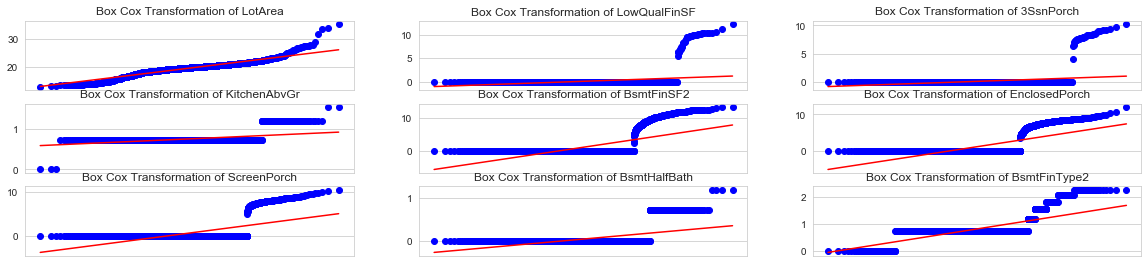

In [22]:
#Displaying Effect of Box Cox Transformation
fig = plt.figure(figsize = (20, 15))

for i, feat in enumerate(skewed_feats):
    if i < 9:
        ax = fig.add_subplot(10, 3, i+1)
        stats.probplot(all_data[feat], plot = plt)
        plt.title("Box Cox Transformation of {}".format(feat))
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.set_xticks([])

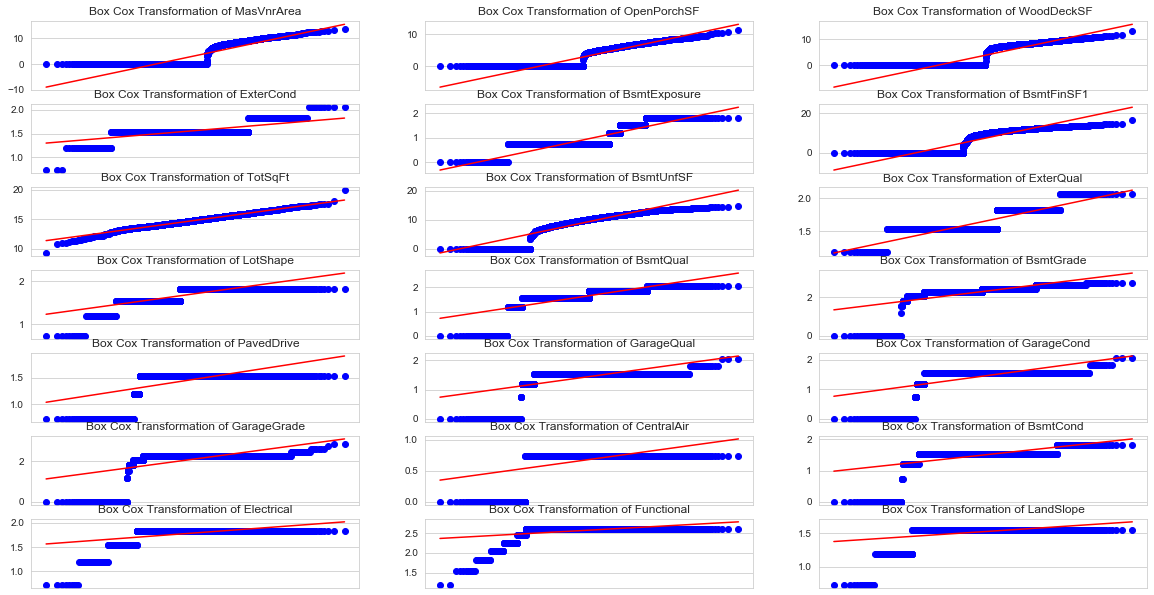

In [23]:
#Displaying Effect of Box Cox Transformation
fig = plt.figure(figsize = (20, 15))

for i, feat in enumerate(skewed_feats):
    if i >=9:
        ax = fig.add_subplot(10, 3, i+1)
        stats.probplot(all_data[feat], plot = plt)
        plt.title("Box Cox Transformation of {}".format(feat))
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.set_xticks([])

In [24]:
#Since all are now int this is not necessary
#all_data = pd.get_dummies(all_data, drop_first = True)

**Splitting Test and Train**  
Now, using the feature I created before merging the test and training sets, which is just a bollean indicating if the observation came from the test or training set, I'll split them again, so I can train my models exclusively on the traning set.

In [25]:
train = all_data.loc[all_data["IsTrain"] == 1, :]
test = all_data.loc[all_data["IsTrain"] == 0, :]

**Log Transformation of Sales Price**  
I'll now apply the log transformation to the SalePrice variable of the training set, which I split off before feature engineering.

In [26]:
#Log transform of SalePrice
y_train = np.log(train_SalePrice)

**Scaled Version of the Training Set**  
At certain points in my modeling I'll want to use and review different types of scaling for the training set, specifically for the neural net created at the end of this analysis. In the mojority of the base modeling I'll just be creating a pipeline which include whichever scaling method I want to use.

In [27]:
#Creating scaled versions of the training and test set
#Standard Scaling
scaler = StandardScaler()
scaler.fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns= train.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns = test.columns)

#Robust Scaling
scaler = RobustScaler()
scaler.fit(train)
train_rob_scal = pd.DataFrame(scaler.transform(train), columns = train.columns)
test_rob_scaled = pd.DataFrame(scaler.transform(test), columns = test.columns)

#Normalizing
scaler = Normalizer()
scaler.fit(train)
train_norm = pd.DataFrame(scaler.transform(train), columns=train.columns)
test_norm = pd.DataFrame(scaler.transform(test), columns = test.columns)

* * *

## Modeling

In [28]:
#Validation Function:
#Adding random shuffle to cross validation folds

def rand_shuf_cv(model, n_folds, train_values = train.values):
    kfolds = KFold(n_folds, shuffle=True, random_state = 84)
    rmse = np.sqrt(-cross_val_score(model, train_values, y_train, scoring = "neg_mean_squared_error", cv = kfolds))
    return(rmse)

#### Pre-Training Functions

I've created two functions, working from work done by Aarshay Jain [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) and [here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/), in order to better fit and score my models as I create, tune, and test them.  
The first of these (modelfit()) is written to handle any sklearn regression or classification model. I'll obviously only be using the regression focused aspects of it here.  
The second (modelfit_xgb()) is written specifically for the sklearn wrapper of the XGBoost model. 

In [29]:
def modelfit(alg, dtrain, predictors, target, preformCV = True, cv_folds = 5, objective = "reg", print_feat_imp = False):
    
    """
    A Model fitting algorithm for sklearn models. The default setup is for regression tasks, but it also supportes
    functionality for classification as well. The objective is set to "reg" for the default regression, if you need
    classification, use objective = "class". 
    Print_feat_imp is set to false by default, as it should only be run if the model has module .feature_importances.
    """
    
    #Fitting the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
    
    #Predicting Training Set
    dtrain_predictions = alg.predict(dtrain[predictors])   
    if objective == "class":
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Preforming Cross Validation
    if preformCV:
        from sklearn.model_selection import cross_val_score
        if objective == "reg":
            cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target],
                                      cv = cv_folds, scoring="neg_mean_squared_error")
        elif objective == "class":
            cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target],
                                      cv = cv_folds, scoring="accuracy")
        else:
            print("Invalid Objective")
        
    #Print Model Report:
    if objective == "reg":
        print("\nModel Report")
        print("Accuracy : {:4g}".format(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
        print("R^2 Score (Train): {}".format(metrics.r2_score(dtrain[target], dtrain_predictions)))
    elif objective == "class":
        print("\nModel Report")
        print("\tAccuracy : {:4g}".format(metrics.accuracy_score(dtrain[target].values, dtrain_predictions)))
        print("\tAUC Score (Train): {}".format(metrics.roc_auc_score(dtrain[target], dtrain_predprob)))
        
    if preformCV:
        print("\tCV Score: Mean = %.4g | Std = %.4g |\n \t\t Min = %.4g | Max = %.4g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
    
    #Plotting Feature Importances
    if print_feat_imp:
        fig = plt.figure(figsize = (15,10))
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending = False)
        ax = feat_imp.plot(kind = "bar", title = "Feature Importances")
        plt.ylabel("Feature Importance Score")
        plt.xticks(rotation = "vertical")
        #The x ticks are shown as the col number by default
        #Here I revise this so they are listed by the feature name
        preds_dict = dict(zip(range(len(predictors)), predictors))
        x_labels = []
        for el in list(feat_imp.index):
            x_labels.append(preds_dict[el])
        plt.xticks(ticks = np.array(range(len(predictors))), 
                  labels = x_labels)

In [30]:
def modelfit_xgb(alg, dtrain, predictors, target, useTrainCV = True, cv_folds = 5, early_stopping_rounds = 50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        #DMatrix is a data matrix used specifically for XGBoost
        #Optimized for both memory effiecncy and training speed
        xgtrain = xgb.DMatrix(dtrain[predictors].values, 
                              label = dtrain[target].values)
        
        cvresult = xgb.cv(xgb_param, xgtrain, 
                           num_boost_round=alg.get_params()['n_estimators'],
                           nfold = cv_folds, metrics = "rmse", 
                           early_stopping_rounds=early_stopping_rounds)
        
        alg.set_params(n_estimators = cvresult.shape[0])
    
    #Fitting the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric = 'rmse')
    
    #Predicting Training Set
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Print Model Report:
    print("\nModel Report")
    print("Accuracy : {:4g}".format(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("R^2 Score (Train): {}".format(metrics.r2_score(dtrain[target], dtrain_predictions)))
    
    #Plotting Feature Importances
    fig = plt.figure(figsize = (15,10))
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending = False)
    ax = feat_imp.plot(kind = "bar", title = "Feature Importances")
    plt.ylabel("Feature Importance Score")
    plt.xticks(rotation = "vertical")
    #The x ticks are shown as the col number by default
    #Here I revise this so they are listed by the feature name
    preds_dict = dict(zip(range(len(predictors)), predictors))
    x_labels = []
    for el in list(feat_imp.index):
        x_labels.append(preds_dict[el])
    plt.xticks(ticks = np.array(range(len(predictors))), 
              labels = x_labels)

### Base Models

In [31]:
#Dataframe to tune model
dtrain = train.copy()
dtrain["SalePrice"] = y_train
predictors = [x for x in dtrain.columns if x not in ["SalePrice"]]

**Lasso Regression**  
As Lasso is somewhat sensitive to outliers, so I'll be using the RobustScaler() in the pipeline. Before creating my pipeline I'll be searching for the best parameters using scikit learn's GirdSearchCV. This is the same method I'll use for the tuneing and training of all of my base models.

In [32]:
#Initial Model
lasso = make_pipeline(RobustScaler(), Lasso(random_state = 10))
modelfit(lasso, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.156771
R^2 Score (Train): 0.0
	CV Score: Mean = -0.1569 | Std = 0.01331 |
 		 Min = -0.1814 | Max = -0.1459


In [ ]:
#Lasso.get_params(Lasso)
param_grid = [{
    "alpha" : [.5, .25, .1, .5, .05, .005, .0005],
    "max_iter" : [5000, 3000, 2000, 1000],
    "tol" : [.1, .01, .001, .0001, .00001]
}]
lasso = Lasso(random_state=10)
clf = GridSearchCV(lasso, param_grid=param_grid, cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [33]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state = 10, alpha = 0.0005, tol = 0.01, max_iter = 5000))

**ElasticNet Regression**  
This model is also notably sensitive to outliers I'll again be using the RobustScaler() in the pipeline.

In [34]:
elastnet = make_pipeline(RobustScaler(), ElasticNet(random_state = 20))
modelfit(elastnet, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.156771
R^2 Score (Train): 0.0
	CV Score: Mean = -0.1569 | Std = 0.01331 |
 		 Min = -0.1814 | Max = -0.1459


In [ ]:
#ElasticNet.get_params(ElasticNet)
param_grid = [{
    "alpha" : [.5, .25, .1, .5, .05, .005, .0005],
    "l1_ratio" : [.99, .95, .9, .8, .75, .5, .25, .1, .5, .05],
    "max_iter" : [5000, 3000, 2500],
    "tol" : [.1, .01, .001]
}]
elastnet = ElasticNet(random_state = 20)

#Filter warnings
warnings.filterwarnings("ignore")

clf = GridSearchCV(elastnet, param_grid=param_grid, 
                   cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [36]:
elastnet = make_pipeline(RobustScaler(), ElasticNet(random_state = 20, alpha = 0.0005, l1_ratio = 0.25, max_iter = 2500, tol = 0.001))

In [37]:
modelfit(elastnet, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.0123989
R^2 Score (Train): 0.9209112566675407
	CV Score: Mean = -0.01413 | Std = 0.0008453 |
 		 Min = -0.01525 | Max = -0.01313


**Ridge Regression**  

In [38]:
ridge = Ridge(random_state = 30)
modelfit(ridge, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.0123137
R^2 Score (Train): 0.9214543379379518
	CV Score: Mean = -0.01413 | Std = 0.000827 |
 		 Min = -0.01526 | Max = -0.01316


In [ ]:
#Ridge.get_params(Ridge)
param_grid = [{
    "alpha" : [.5, .25, .1, .5, .05, .005, .0005],
    "max_iter" : [5000, 3000, 2000, 1000],
    "tol" : [0.1, 0.01, 0.001, 0.0001]
}]

#Filter warnings
warnings.filterwarnings("ignore")

clf = GridSearchCV(ridge, param_grid=param_grid, 
                   cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [39]:
ridge = Ridge(alpha = 0.05, max_iter = 5000, tol = 0.1, random_state= 30)

In [40]:
modelfit(ridge, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.0122251
R^2 Score (Train): 0.922019610894948
	CV Score: Mean = -0.01412 | Std = 0.0007804 |
 		 Min = -0.01514 | Max = -0.01321


**Kernel Ridge**

In [41]:
k_ridge = KernelRidge()
k_ridge.get_params()

{'alpha': 1,
 'coef0': 1,
 'degree': 3,
 'gamma': None,
 'kernel': 'linear',
 'kernel_params': None}

In [42]:
#Initial Model
k_ridge = KernelRidge(kernel="polynomial")
modelfit(k_ridge, dtrain, predictors, "SalePrice")

C:\Users\samru\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.58685e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\samru\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.28745e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\samru\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.23628e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\samru\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42491e-17): result may not be accurate.
  overwrite_a=False)



Model Report
Accuracy : 1.33006e-05
R^2 Score (Train): 0.9999151593891498
	CV Score: Mean = -0.1774 | Std = 0.08015 |
 		 Min = -0.3334 | Max = -0.1041


C:\Users\samru\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.00687e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\samru\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.66254e-17): result may not be accurate.
  overwrite_a=False)


In [ ]:
#Tuning Parameters
param_grid = [{
    "degree" : [2,3,4],
    "coef0" : [0.5,1,1.5,2,2.5,3],
    "gamma" : [0, 0.05, 0.25, 0.5, 0.75, 1]
}]

clf = GridSearchCV(k_ridge, param_grid=param_grid,
                   scoring = "neg_mean_squared_error",
                   cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Fine Tuning Coef0
param_grid = [{
    "coef0" : [1.5, 1.75, 2, 2.25, 2.5]
}]

k_ridge = KernelRidge(kernel="polynomial", degree = 2, gamma = .05)

clf = GridSearchCV(k_ridge, param_grid=param_grid,
                   scoring = "neg_mean_squared_error",
                   cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [43]:
k_ridge = KernelRidge(kernel="polynomial", degree = 2, coef0=2, gamma = 0.05)
modelfit(k_ridge, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.00171612
R^2 Score (Train): 0.9890533559456667
	CV Score: Mean = -0.04349 | Std = 0.004729 |
 		 Min = -0.04773 | Max = -0.0353


**ARD Regression**

In [44]:
from sklearn.linear_model import ARDRegression
ard = ARDRegression()
ard.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'n_iter': 300,
 'normalize': False,
 'threshold_lambda': 10000.0,
 'tol': 0.001,
 'verbose': False}

In [45]:
modelfit(ard, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.0142901
R^2 Score (Train): 0.9088473280025899
	CV Score: Mean = -0.01459 | Std = 0.001039 |
 		 Min = -0.01605 | Max = -0.01302


In [ ]:
param_grid = [{
    "n_iter" : [20, 25, 30, 40, 50],
    "alpha_1" : [1e6, 1e5, 1e4],
    "alpha_2" : [1e6, 1e5, 1e4]
}]

clf = GridSearchCV(ard, param_grid=param_grid, cv =5, 
                  scoring = "neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
param_grid = [{
    "n_iter" : [10, 15, 20, 25],

}]

ard = ARDRegression(alpha_1=1e6, alpha_2=1e4)

clf = GridSearchCV(ard, param_grid=param_grid, cv =5, 
                  scoring = "neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [46]:
ard = ARDRegression(alpha_1=1e6, alpha_2=1e4, n_iter = 15)
modelfit(ard, dtrain, predictors, "SalePrice")


Model Report
Accuracy : 0.0135397
R^2 Score (Train): 0.913634180677723
	CV Score: Mean = -0.01451 | Std = 0.0009453 |
 		 Min = -0.01583 | Max = -0.01304


**Random Forest Regression**

In [47]:
rf = RandomForestRegressor(random_state=135)
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 135,
 'verbose': 0,
 'warm_start': False}

C:\Users\samru\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Model Report
Accuracy : 0.00360103
R^2 Score (Train): 0.9770300787111736
	CV Score: Mean = -0.01923 | Std = 0.002114 |
 		 Min = -0.02099 | Max = -0.01571


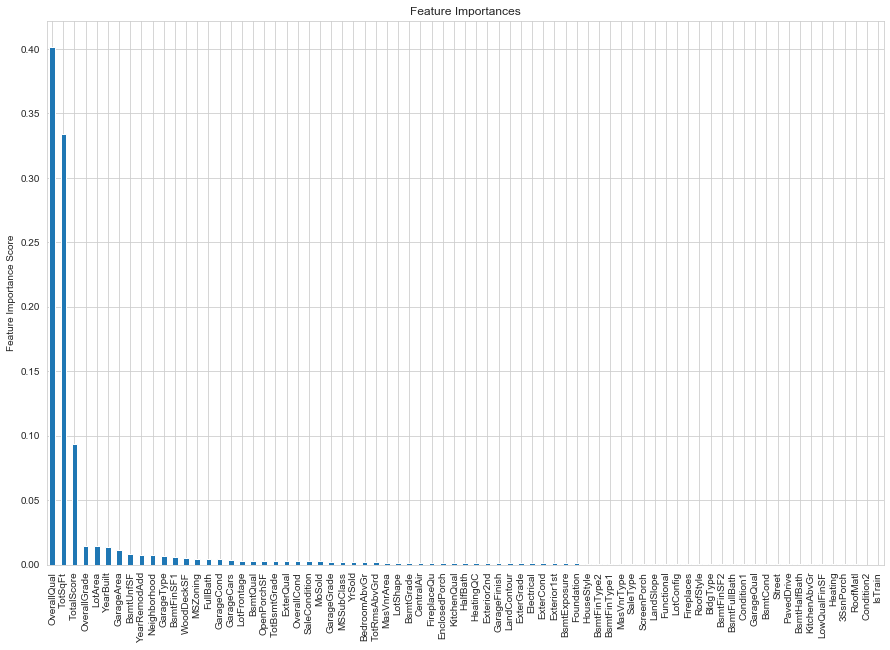

In [48]:
modelfit(rf, dtrain, predictors, "SalePrice", print_feat_imp=True)

In [ ]:
#Tuning
param_grid = [{
    "max_features" : ["auto", "sqrt"],
    "max_depth" : [10, 20, 30, 40, 50],
    "min_samples_leaf" : [1,2,4,8],
    "min_samples_split" : [2, 5, 10],
    "n_estimators" : [125, 150, 175]
}]

clf = GridSearchCV(rf, param_grid=param_grid, cv = 5,
                  scoring = "neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_


Model Report
Accuracy : 0.00239888
R^2 Score (Train): 0.9846982230847666
	CV Score: Mean = -0.01712 | Std = 0.001123 |
 		 Min = -0.01839 | Max = -0.01539


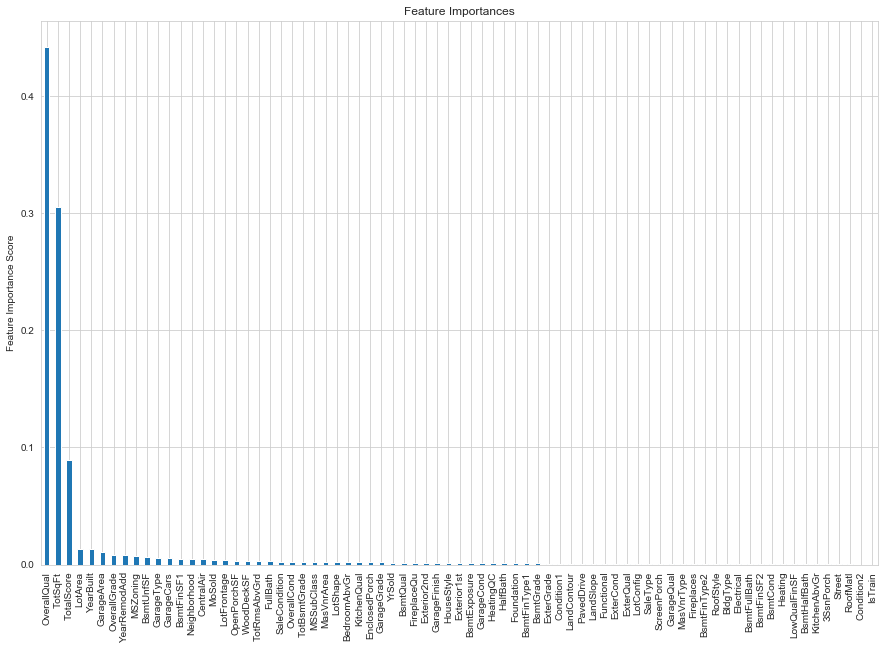

In [49]:
rf = RandomForestRegressor(random_state= 135,
                           max_depth= 30,
                           max_features= "auto",
                           min_samples_leaf= 1,
                           min_samples_split= 2,
                           n_estimators= 150)
modelfit(rf, dtrain, predictors, "SalePrice", print_feat_imp=True)
plt.savefig("Images/RandomForestFeatImp.png")

**Gradient Boosting Regression**  



Model Report
Accuracy : 0.00685925
R^2 Score (Train): 0.9562467994428997
	CV Score: Mean = -0.01477 | Std = 0.001871 |
 		 Min = -0.01738 | Max = -0.01232


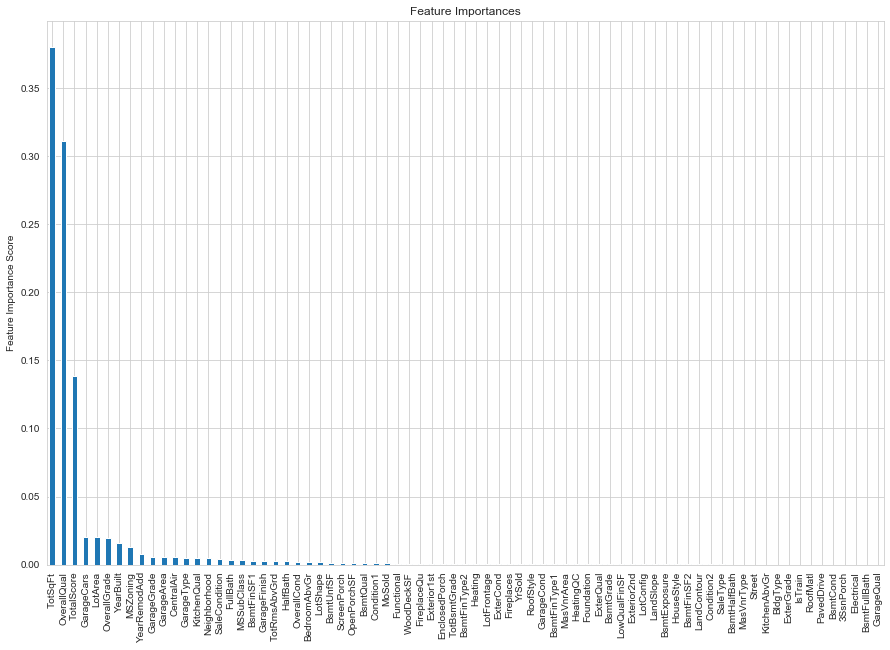

In [50]:
gbm = GradientBoostingRegressor(random_state=40)
modelfit(gbm, dtrain, predictors, "SalePrice", print_feat_imp=True)

In [ ]:
#GradientBoostingRegressor.get_params(GradientBoostingRegressor)

#Tuneing Estimators
param_grid = [{
    "n_estimators" : [1500, 1000, 500, 250, 200, 100, 50]
}]


gbm = GradientBoostingRegressor(min_samples_split=110,
                                max_depth=5,
                                max_features="sqrt",
                                subsample=0.8, 
                                min_samples_leaf=30, 
                                random_state = 40)
clf = GridSearchCV(gbm, param_grid=param_grid,
                  cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Tuneing max_depth and min_samples_split
#Using estimators found above
param_grid = [{
    "max_depth" : range(3, 10, 2),
    "min_samples_split" : range(50, 150, 10)
}]
gbm = GradientBoostingRegressor(n_estimators=250,
                                max_features="sqrt",
                                subsample=0.8, 
                                min_samples_leaf=30, 
                                random_state = 40)
clf = GridSearchCV(gbm, param_grid=param_grid,
                  cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Fine tuneing max_depth and min_samples_split
#Using nestimators found above
param_grid = [{
    "max_depth" : [3,4,5,6,7],
    "min_samples_split" : [130, 135, 140, 145, 150, 155]
}]
gbm = GradientBoostingRegressor(n_estimators=250,
                                max_features="sqrt",
                                subsample=0.8, 
                                min_samples_leaf=30, 
                                random_state = 40)
clf = GridSearchCV(gbm, param_grid=param_grid,
                  cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Tuneing min_samples_leaf and subsample
#Using nestimators, max_depth, and min_samples_split found above
param_grid = [{
    "min_samples_leaf" : range(10, 71, 10),
    "subsample" : [i/10. for i in range(6,11)]
}]
gbm = GradientBoostingRegressor(n_estimators=250,
                                max_depth =5,
                                min_samples_split=140,
                                max_features="sqrt", 
                                random_state = 40)
clf = GridSearchCV(gbm, param_grid=param_grid,
                  cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Fine tuneing min_samples_leaf and subsample
#Using nestimators, max_depth, and min_samples_split found above
param_grid = [{
    "min_samples_leaf" : [10, 15, 20, 25, 30],
    "subsample" : [.5, .55, .6, .65, .7]
}]

gbm = GradientBoostingRegressor(n_estimators=250,
                                max_depth =5,
                                min_samples_split=140,
                                max_features="sqrt", 
                                random_state = 40)
clf = GridSearchCV(gbm, param_grid=param_grid,
                  cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Tuneing max_features, learning_rate, and loss
#Using nestimators, max_depth, min_samples_leaf, and subsample, and min_samples_split found above
param_grid = [{
    "max_features" : ["sqrt", "log2"],
    "learning_rate" : [.25, .2, .15, .1, .05, .005],
    "loss" : ["huber", "ls"]
}]
gbm = GradientBoostingRegressor(n_estimators=250,
                                max_depth =10,
                                min_samples_split=85,
                                max_features="sqrt", 
                                random_state = 40,
                                min_samples_leaf=15,
                                subsample=0.6)
clf = GridSearchCV(gbm, param_grid=param_grid,
                  cv = 5, scoring="neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [51]:
gbm = GradientBoostingRegressor(n_estimators=250,
                                max_depth =10,
                                min_samples_split=85,
                                max_features="sqrt", 
                                random_state = 40,
                                min_samples_leaf=15,
                                subsample=0.6,
                                learning_rate=0.05,
                                loss = "huber")


Model Report
Accuracy : 0.00685098
R^2 Score (Train): 0.9562995847127195
	CV Score: Mean = -0.01406 | Std = 0.001458 |
 		 Min = -0.01608 | Max = -0.01229


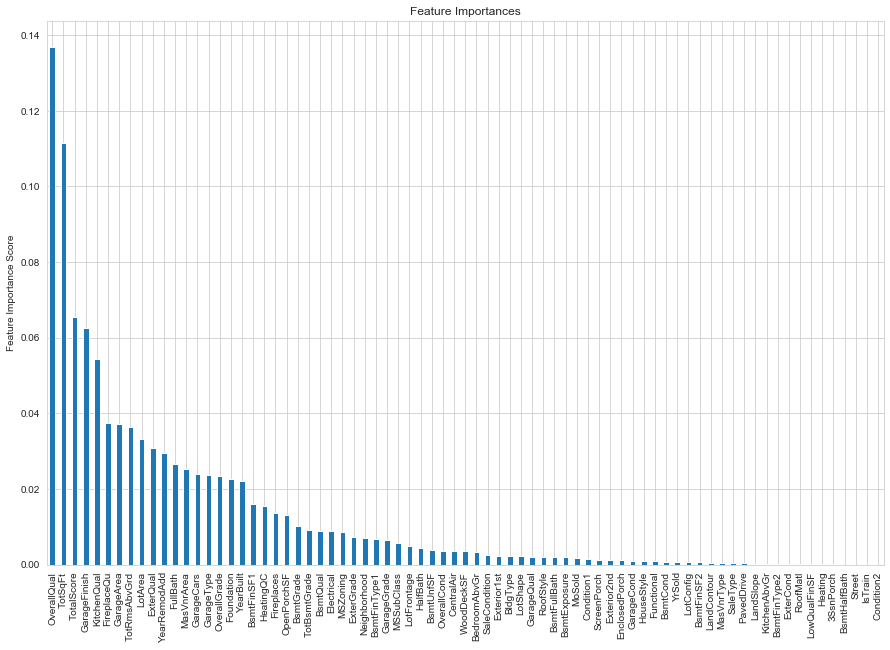

In [52]:
modelfit(gbm, dtrain, predictors, "SalePrice", print_feat_imp=True)
plt.savefig("Images/GBMFeatImp.png")

**XG Boost Regression**  
I'm using the sklearn wrapper for the XGBoost Regressor, so that I can utilize the GridSearchCV() funtion to tune the hyper parameters of this model. 

In [53]:
xgboost = XGBRegressor() 
#xgboost.get_xgb_params()


Model Report
Accuracy : 0.00343205
R^2 Score (Train): 0.9781079189322223


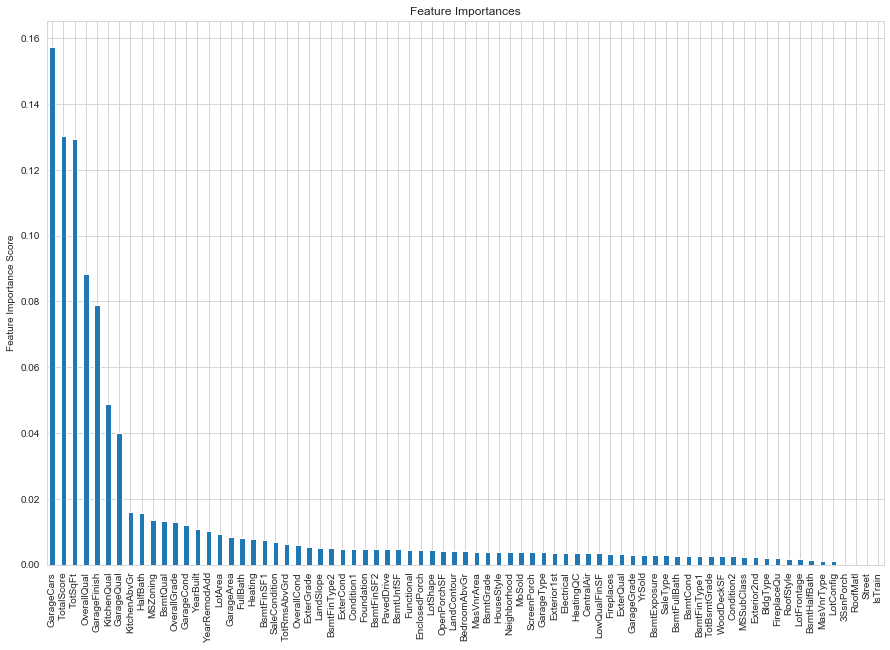

In [54]:
#Initial Model
xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=100,
                       max_depth=5,
                       min_child_weight=1,
                       objective= "reg:squarederror",
                       gamma = 0,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       nthread=4,
                       scale_pos_weight=1,
                       seed=27)
#Filtering Warnings
warnings.filterwarnings("ignore")
#Model fit
modelfit_xgb(xgboost, dtrain, predictors, "SalePrice")

In [ ]:
#Tuneing n_estimators
param_grid = [{
    "n_estimators" : [1250, 1000, 800, 600, 400, 250, 200, 100]
}]

#Filtering Warnings
warnings.filterwarnings("ignore")

clf = GridSearchCV(xgboost, param_grid=param_grid, scoring = "neg_mean_squared_error", cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Tuneing max_depth, min_child_weight
#Using n_estimators found above
param_grid = [{
    "max_depth" : range(3, 10, 2),
    "min_child_weight" : range(1, 6, 2)
}]

#Filtering Warnings
warnings.filterwarnings("ignore")

xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=200,
                       objective= "reg:squarederror",
                       gamma = 0,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       nthread=4,
                       scale_pos_weight=1,
                       seed=27)

clf = GridSearchCV(xgboost, param_grid=param_grid, scoring = "neg_mean_squared_error", cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Fine tuneing max_depth and min_child_weight
#Using n_estimators found above
param_grid = [{
    "max_depth" : [4,5,6],
    "min_child_weight" : [2,3,4]
}]
xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=200,
                       objective= "reg:squarederror",
                       gamma = 0,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       nthread=4,
                       scale_pos_weight=1,
                       seed=27)
#Filtering Warnings
warnings.filterwarnings("ignore")

clf = GridSearchCV(xgboost, param_grid=param_grid, scoring = "neg_mean_squared_error", cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Tuneing gamma
#Using n_estimators, max_depth, min_child_weight found above
param_grid = [{
    "gamma" : [i/10.0 for i in range(5)]
}]
xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=200,
                       max_depth= 5,
                       min_child_weight= 3,
                       objective= "reg:squarederror",
                       nthread=4,
                       subsample=0.9,
                       scale_pos_weight=1,
                       seed=27)
#Filtering Warnings
warnings.filterwarnings("ignore")

clf = GridSearchCV(xgboost, param_grid=param_grid, scoring = "neg_mean_squared_error", cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Tuneing subsample
#Using n_estimators, max_depth, min_chil_weight found above
#gamma best at default 0
param_grid = [{
    "subsample" : [i/10.0 for i in range(6,11)]
}]
xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=200,
                       max_depth= 5,
                       min_child_weight= 3,
                       objective= "reg:squarederror",
                       nthread=4,
                       scale_pos_weight=1,
                       seed=27)
#Filtering Warnings
warnings.filterwarnings("ignore")

clf = GridSearchCV(xgboost, param_grid=param_grid, scoring = "neg_mean_squared_error", cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Tuneing col_sample_bytree
#Using n_estimators, max_depth, min_chil_weight found above
#gamma best at default 0
#subsample best at 0.9
param_grid = [{
    "colsample_bytree" : [i/10.0 for i in range(6,11)]
}]
xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=200,
                       max_depth= 5,
                       min_child_weight= 3,
                       objective= "reg:squarederror",
                       nthread=4,
                       subsample=0.9,
                       scale_pos_weight=1,
                       seed=27)
#Filtering Warnings
warnings.filterwarnings("ignore")

clf = GridSearchCV(xgboost, param_grid=param_grid, scoring = "neg_mean_squared_error", cv = 5)
clf.fit(train, y_train)
clf.best_params_

In [55]:
xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=200,
                       max_depth= 5,
                       min_child_weight= 3,
                       objective= "reg:squarederror",
                       nthread=4,
                       subsample=0.9,
                       col_sample_bytree = 0.8,
                       scale_pos_weight=1,
                       seed=27)


Model Report
Accuracy : 0.00186448
R^2 Score (Train): 0.9881070008690958


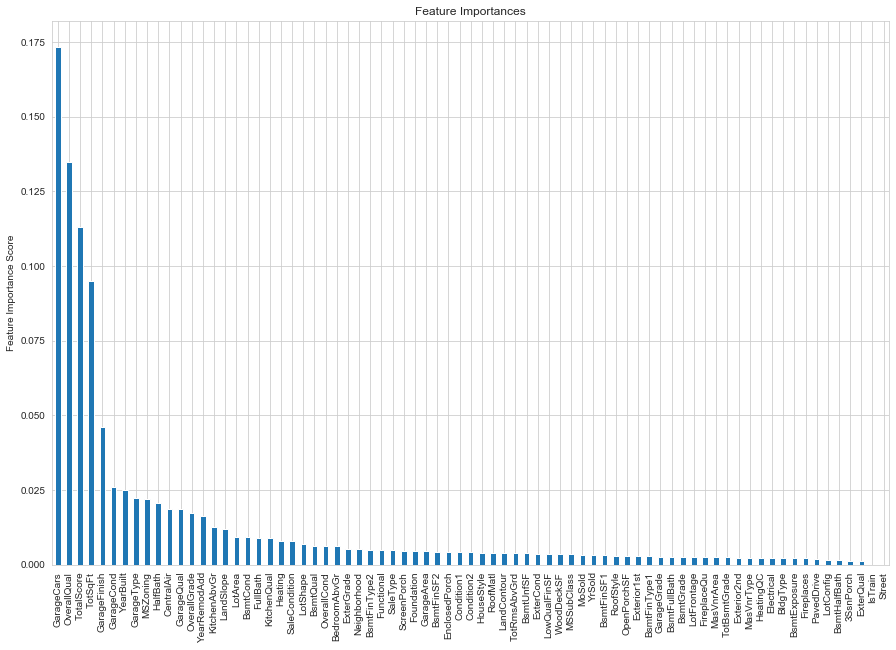

In [56]:
modelfit_xgb(xgboost, dtrain, predictors, "SalePrice")
plt.savefig("Images/XGBoostFeatImp.png")

**AdaBoost Regression**

In [57]:
from sklearn.ensemble import AdaBoostRegressor

In [58]:
ada = AdaBoostRegressor(random_state = 80)
ada.get_params()

{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 80}


Model Report
Accuracy : 0.020218
R^2 Score (Train): 0.8710349393346783
	CV Score: Mean = -0.02432 | Std = 0.001192 |
 		 Min = -0.02575 | Max = -0.02262


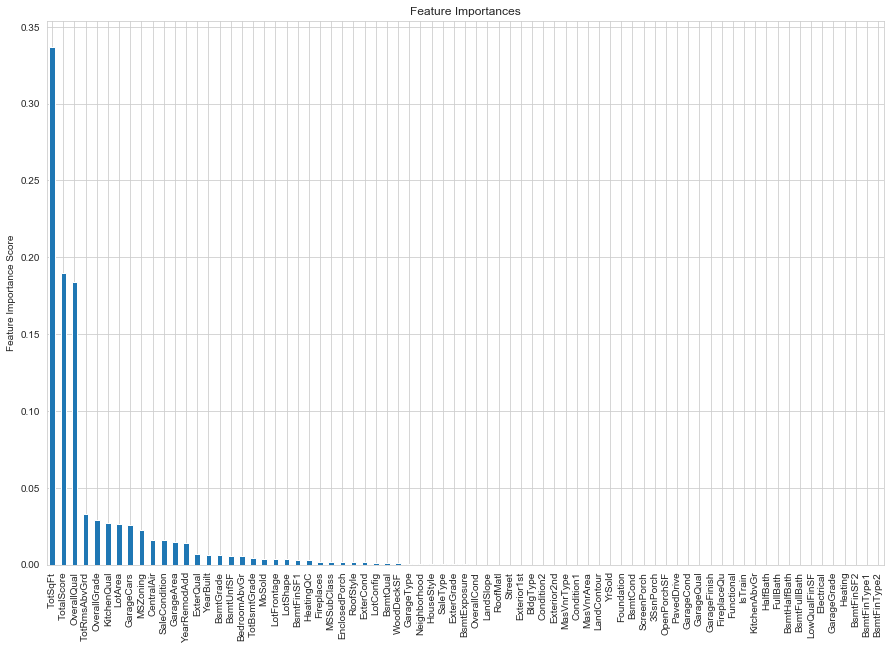

In [59]:
modelfit(ada, dtrain, predictors, "SalePrice", print_feat_imp=True)

In [ ]:
#Tuning Parameters
param_grid = [{
    "learning_rate" : [1, .5, .25, .1, 0.05],
    "n_estimators" : [25, 50, 75, 100, 125],
    "loss" : ['linear', 'square', 'exponential']
}]

clf = GridSearchCV(ada, param_grid=param_grid, cv = 5,
                  scoring = "neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Fine Tuneing Parameters
param_grid = [{
    "learning_rate" : [.30, .25, .2, .15],
    "n_estimators" : range(85, 116, 5),
}]

#Linear loss is the default, so no need to reinitialize the model

clf = GridSearchCV(ada, param_grid=param_grid, cv = 5,
                  scoring = "neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_

In [ ]:
#Fine Tuneing Parameters
param_grid = [{
    "learning_rate" : [.18, .15, .12, .1, .05],
    "n_estimators" : range(110, 141,5),
}]

#Linear loss is the default
#so no need to reinitialize the model

clf = GridSearchCV(ada, param_grid=param_grid, cv = 5,
                  scoring = "neg_mean_squared_error")
clf.fit(train, y_train)
clf.best_params_


Model Report
Accuracy : 0.0198977
R^2 Score (Train): 0.8730785705201659
	CV Score: Mean = -0.024 | Std = 0.001723 |
 		 Min = -0.02594 | Max = -0.02175


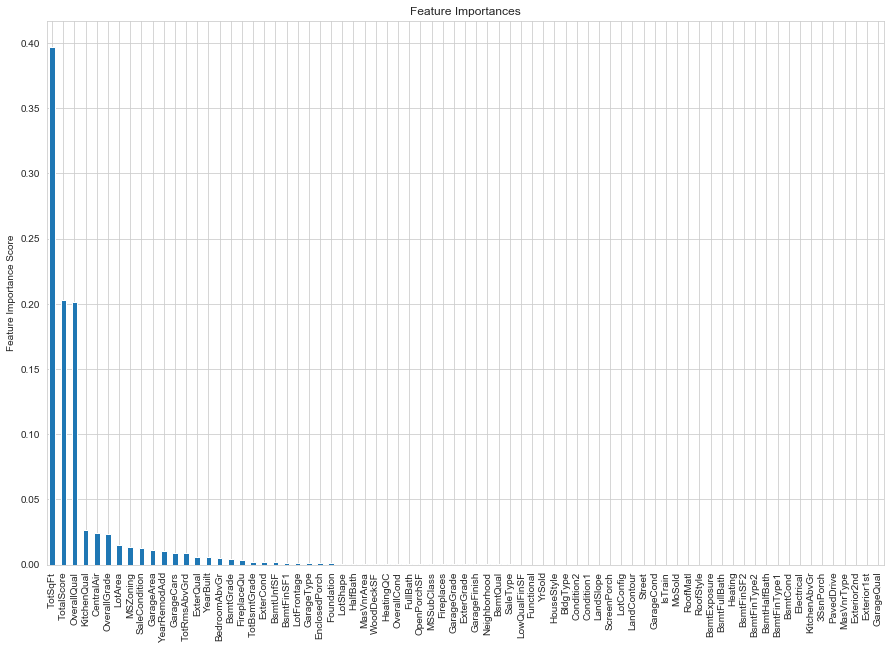

In [60]:
ada = AdaBoostRegressor(learning_rate=0.15, n_estimators=135, 
                       random_state=80)
modelfit(ada, dtrain, predictors, "SalePrice", print_feat_imp=True)
plt.savefig("Images/ADABoostFeatImp.png")

### Base Model Scores

**Lasso Score**

In [61]:
score = rand_shuf_cv(lasso, 5)
score.mean()

0.11852426585154985

**ElasticNet Score**

In [62]:
score = rand_shuf_cv(elastnet, 5)
score.mean()

0.11821903164609988

**Ridge Score**

In [63]:
score = rand_shuf_cv(ridge, 5)
score.mean()

0.11786376027706424

**Kernel Ridge Score**

In [64]:
score = rand_shuf_cv(k_ridge, 5)
score.mean()

0.2069713051388668

**ARD Regression Score**

In [65]:
score = rand_shuf_cv(ard, 5)
score.mean()

0.12055549767723361

**Random Forest Score**

In [66]:
score = rand_shuf_cv(rf, 5)
score.mean()

0.1325847500850868

**GBM Score**

In [67]:
score = rand_shuf_cv(gbm, 5)
score.mean()

0.11830509638459649

**XGBoost Score**

In [68]:
#Filtering Warnings
warnings.filterwarnings("ignore")

score = rand_shuf_cv(xgboost, 5)
score.mean()

0.11911699155284869

**ADA Boost Regression Score**

In [69]:
score = rand_shuf_cv(ada, 5)
score.mean()

0.1569582139208081

* * *

## Stacking Models

The following code is inspired by [Serigne's Stacked Model Code](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard), as much of this modeling analysis is based on his premise of stacked models. 

### Method One: Averaging the Base Models

I'll be building a new class to extend sklearn and allow for easy averaging.

In [70]:
class AverageModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    #Defining clones of the original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        #Training the cloned models
        for model in self.models_:
            model.fit(X,y)
        
        return(self)
    
    #Predicting the cloned models and averaging them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return(np.mean(predictions, axis = 1))

**Creating the Averaged Based Models**

In [71]:
averaged_models = AverageModel(models = (lasso, elastnet, gbm, ridge))

**Averaged Models Score**

In [72]:
score = rand_shuf_cv(averaged_models, 5)
score.mean()

0.11376858582046494

**Adding XGBoost**

In [73]:
averaged_xgb= AverageModel(models = (xgboost, averaged_models))

In [74]:
score = rand_shuf_cv(averaged_xgb, 5)
score.mean()

0.11194235390761578

**Adding ARD Regression**

In [75]:
averaged_xgb_ard = AverageModel(models = (ard, averaged_xgb))

In [76]:
score = rand_shuf_cv(averaged_xgb_ard, 5)
score.mean()

0.11328196438406572

**Averaging the Ensemble Methods**

In [77]:
averaged_ensemble = AverageModel(models = (xgboost, gbm, rf))

In [78]:
score = rand_shuf_cv(averaged_ensemble, 5)
score.mean()

0.11719138090246128

### Method 2: Adding a Meta Model

Now I'll create a class for stacking the averaged models.

In [79]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
        def __init__(self, base_models, meta_model, n_folds = 5):
            self.base_models = base_models
            self.meta_model = meta_model
            self.n_folds = n_folds
            
        #Fitting the data on clones of the original models
        def fit(self, X, y):
            self.base_models_ = [list() for x in self.base_models]
            self.meta_model_ = clone(self.meta_model)
            folds = KFold(n_splits = self.n_folds, shuffle=True, random_state=168)
            
            #Training the cloned models and creating out-of-fold predictions
            #the later will be used for the meta model
            out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
            for i, model in enumerate(self.base_models):
                for train_index, holdout_index in folds.split(X):
                    instance = clone(model)
                    self.base_models_[i].append(instance)
                    instance.fit(X[train_index], np.asarray(y, dtype = "float64")[train_index])
                    y_pred = instance.predict(X[holdout_index])
                    out_of_fold_predictions[holdout_index, i] = y_pred
                    
            #Now Training the cloned meta-model using out of fold predictions
            #as a new feature
            self.meta_model_.fit(out_of_fold_predictions, y)
            
            return self
        
        #Predictions of all base models using the test data
        #using the avereaged predictions as meta features
        #final prediciton is handled by meta model
        def predict(self, X):
            meta_features = np.column_stack(
                [np.column_stack(
                    [model.predict(X) for model in base_models]).mean(axis = 1) 
                 for base_models in self.base_models_])
            return self.meta_model_.predict(meta_features)

 **Stacked Averaged Base Models**

In [80]:
stacked_average_models = StackingAveragedModels(
    base_models = (elastnet, ridge, gbm),
    meta_model = lasso)

In [81]:
score = rand_shuf_cv(stacked_average_models, 5)
score.mean()

0.11328593050867293

**Adding XGB to the Stacked Averaged Model**

In [82]:
stacked_average_models_xgb = StackingAveragedModels(
    base_models = (elastnet, ridge, gbm, lasso),
    meta_model = xgboost)

In [83]:
score = rand_shuf_cv(stacked_average_models_xgb, 5)
score.mean()

0.12207974237093047

**Stacked Averaged Ensemble**

In [84]:
stacked_averaged_ensemble = StackingAveragedModels(
    base_models=(rf, xgboost), meta_model=gbm)

In [85]:
score = rand_shuf_cv(stacked_averaged_ensemble, 5)
score.mean()

0.12321999627632799

**Stacked Averaged Models with Elasticnet Meta Model**

In [86]:
stacked_averged_ELmeta = StackingAveragedModels(
    base_models = (ridge, lasso, gbm, xgboost, ),
    meta_model = elastnet)

In [87]:
score = rand_shuf_cv(stacked_averged_ELmeta, 5)
score.mean()

0.11140912119563358

* * *

### Submissions

**XGBoost Model Predictions**

In [ ]:
xgboost.fit(train[predictors], y_train)
logpreds = xgboost.predict(data = test)

In [ ]:
preds = np.exp(logpreds)
preds_df = pd.concat([test_id, pd.Series(preds, name = "SalePrice")], axis = 1)
preds_df.to_csv("PythonPreds/xgboost_2_preds.csv", index = False)

**First Averaged Model Predictions**

In [ ]:
averaged_models.fit(train, y_train)
logpreds = averaged_models.predict(test)

In [ ]:
preds = np.exp(logpreds)
preds_df = pd.concat([test_id, pd.Series(preds, name = "SalePrice")], axis = 1)
preds_df.to_csv("PythonPreds/averaged_models.csv", index = False)

**Averaged Models with XGBoost**

In [ ]:
averaged_xgb.fit(train, y_train)
logpreds = averaged_xgb.predict(test)

In [ ]:
preds = np.exp(logpreds)
preds_df = pd.concat([test_id, pd.Series(preds, name= "SalePrice")], axis = 1)
preds_df.to_csv("PythonPreds/averaged_xgb.csv", index = False)

**Averaged Models with XGBoost and ARD**

In [ ]:
averaged_xgb_ard.fit(train, y_train)
logpreds = averaged_xgb_ard.predict(test)

In [ ]:
preds = np.exp(logpreds)
preds_df = pd.concat([test_id, pd.Series(preds, name= "SalePrice")], axis = 1)
preds_df.to_csv("PythonPreds/averaged_xgb_ard.csv", index = False)

**Stacked Average Models**

In [ ]:
stacked_average_models.fit(train.values, y_train)
logpreds = stacked_average_models.predict(test)

In [ ]:
preds = np.exp(logpreds)
preds_df = pd.concat([test_id, pd.Series(preds, name= "SalePrice")], axis = 1)
preds_df.to_csv("PythonPreds/stacked_averaged.csv", index = False)

**Stacked Averaged Models with XGBoost**

In [ ]:
stacked_average_models_xgb.fit(train.values, y_train)
logpreds = stacked_average_models_xgb.predict(test)

In [ ]:
preds = np.exp(logpreds)
preds_df = pd.concat([test_id, pd.Series(preds, name= "SalePrice")], axis = 1)
preds_df.to_csv("PythonPreds/stacked_averaged_xgb.csv", index = False)

**Stacked Base Models with Elasticnet Meta Model**

In [ ]:
stacked_averged_ELmeta.fit(train.values, y_train)
logpreds = stacked_averged_ELmeta.predict(test.values)

In [ ]:
preds = np.exp(logpreds)
preds_df = pd.concat([test_id, pd.Series(preds, name= "SalePrice")], axis = 1)
preds_df.to_csv("PythonPreds/stacked_elast_meta.csv", index = False)